In [1]:
#생성기와 판별기가 포함된 tensorflow-examples을 가져온다.
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
#데이터 셋 준비
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteUC164N/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteUC164N/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteUC164N/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteUC164N/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
#이미지를 랜덤으로 자르는 함수
def random_crop(image):
  #random_crop메서드는 주어진 이미지텐서를 size대로 무작위로 자릅니다.
  cropped_image = tf.image.random_crop(
      #rgb컬러 이미지이므로 마지막 채널을 3으로 준다.
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [7]:
#이미지의 rgb값을 [-1,1]로 평준화하는 함수
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [8]:
#지터링 함수 정의
def random_jitter(image):
  #286x286x3로 이미지를 리사이즈 한다.
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  #랜덤 크로핑
  image = random_crop(image)

  #랜덤 로테이트
  image = tf.image.random_flip_left_right(image)

  return image

In [9]:
#훈련 이미지 전처리 함수 정의
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
#테스트 이미지 전처리 함수 정의
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [11]:
#각각의 tensorflow dataset을 매핑

train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

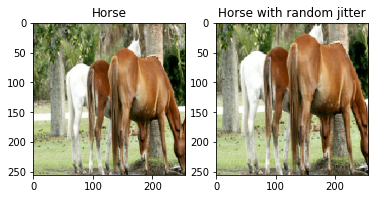

In [12]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)
#Horse샘플과 그것을 지터링한 이미지를 표시

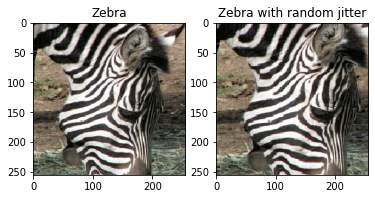

In [13]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)
#zebra샘플 하나와 그것을 지터링한 이미지를 표시

# **Cycle GAN**
Cycle GAN은 두개의 생성기(G,F)와 두개의 판별기(X,Y)를 사용하는 GAN모델입니다. G는 X이미지를 Y이미지로 바꾸는 법을, F는 Y이미지를 X이미지로 바꾸는 법을 학습하게 됩니다. 판별기 X는 X이미지의 진위를 구분, Y는 Y이미지의 진위를 구분하는 법을 학습합니다.

**Pix2Pix모델 가져오기**

In [14]:
#rgb이미지로 출력하므로 3개의 채널을 사용합니다.
OUTPUT_CHANNELS = 3

#Cycle GAN의 논문에선 변형된 renet을 생성자로 쓰지만 이번 예제에선 pix2pix하위의 변형된 Unet을 사용합니다.
#Cycle GAN은 특수하게 인스턴스 정규화(instancenorm)을 사용합니다.
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

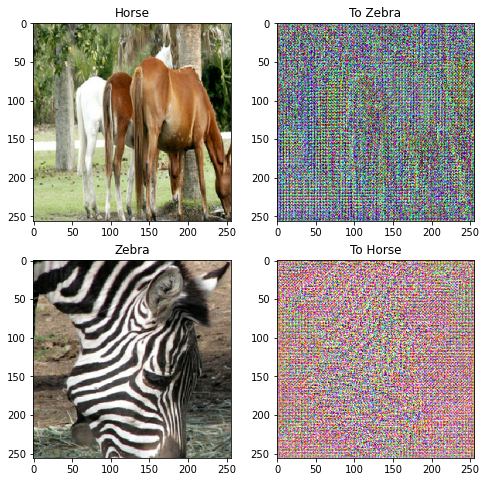

In [15]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()
#학습되지 않고 말을 얼룩말로, 얼룩말을 말로 변환

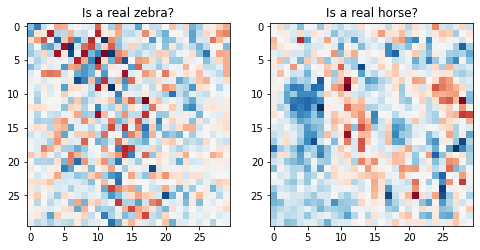

In [16]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()
#학습되지 않은 판별기로 판별

**손실함수**

제대로된 target데이터 없이 학습하므로 Cycle GAN논문에선 주기 일관성 손실함수를 제안합니다. 이번 예제에선 pix2pix에서 사용된 손실함수와 유사함 함수를 사용합니다. 주기 일관성이란 입력과 결과가 유사해야함을 말합니다. 따라서 이 Cycle GAN모델은 손실함수의 입력과 결과가 같도록 하는 방향으로 학습합니다.

In [17]:
LAMBDA = 10

In [18]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [20]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [21]:
#실제 이미지와 한번 순환된 이미지 사이의 오차 절댓값의 평균을 반환합니다.
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [22]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [23]:
#모든 생성기와 판별기의 옵티마이저 초기화
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

**체크 포인트**

In [24]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

**훈련**

In [25]:
EPOCHS = 40

In [26]:
#이미지를 생성하고 표시하는 함수 정의
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Cycle GAN의 훈련은 다음 4단계로 나뉩니다.

1.   예측을 얻습니다.
2.   손실을 계산합니다.
3.   역전파를 사용하여 그래디언트를 계산합니다.
4.   그래디언트를 옵티마이저에 적용합니다.

In [27]:
#훈련 루프 정의
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:

    #real_x를 사용하여 fake_y를 예측
    fake_y = generator_g(real_x, training=True)
    #이후 fake_y를 사용하여 한번 순환한 cycled_x를 예측
    cycled_x = generator_f(fake_y, training=True)

    #같은 방법으로 real_y를 이용하여 fake_x를 예측
    fake_x = generator_f(real_y, training=True)
    #fake_x를 이용하여 한번 순환한 cycled_y를 예측
    cycled_y = generator_g(fake_x, training=True)

    #generator_f를 사용하여 이미지 X를 X로 변환
    same_x = generator_f(real_x, training=True)
    #같은 방법으로 이미지Y를 Y로 변환
    #이는 generator가 제대로 생성하는지 측정하기 위함이다.
    same_y = generator_g(real_y, training=True)

    #각각의 판별 결과를 저장
    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)
    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    #위조된 이미지에 대한 generator_loss를 계산
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    #전체 Cycle GAN의 손실함수는 진짜 x,y와 각각을 순환한 cycled_x,y를 이용해 계산한 Cycle GAN손실함수를 더한 값이된다.
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    #전체 generator_g의 손실함수는 앞서 구한 위조된 Y이미지에 대한 generator_loss와 전체 Cycle GAN의 손실, 이후 Y이미지에대한 identity_loss를 더한 값이 된다.
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    #전체 generator_f의 손실함수는 앞서 구한 위조된 X이미지에 대한 generator_loss와 전체 Cycle GAN의 손실, 이후 X이미지에대한 identity_loss를 더한 값이 된다.
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    #전체 판별기 손실은 각각의 판별결과를 에 대한 discriminator_loss이다.
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  #그래디언트를 계산
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  #옵티마이저에 그래디언트를 적용
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

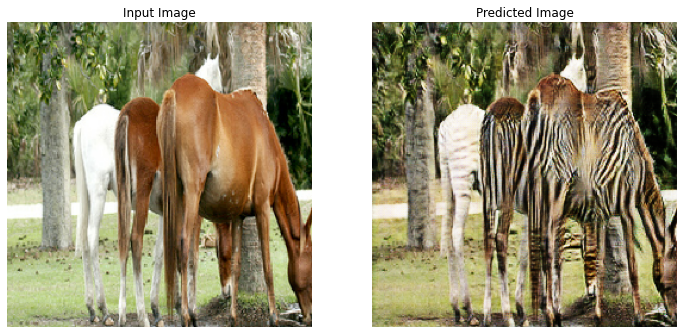

Time taken for epoch 29 is 850.5869107246399 sec

.................................

In [ ]:
#훈련
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))